<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Откроем-и-изучим-данные" data-toc-modified-id="Откроем-и-изучим-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Откроем и изучим данные</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Разложение-временного-ряда-на-компоненты" data-toc-modified-id="Разложение-временного-ряда-на-компоненты-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Разложение временного ряда на компоненты</a></span></li><li><span><a href="#Стационарность-временного-ряда" data-toc-modified-id="Стационарность-временного-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Стационарность временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression-тестирование" data-toc-modified-id="LinearRegression-тестирование-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression тестирование</a></span></li><li><span><a href="#DecisionTreeRegressor-тестирование" data-toc-modified-id="DecisionTreeRegressor-тестирование-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>DecisionTreeRegressor тестирование</a></span></li><li><span><a href="#LightGBM-тестирование" data-toc-modified-id="LightGBM-тестирование-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM тестирование</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

### Откроем и изучим данные

In [40]:
#импортируем необходимые библиотеки
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pylab import rcParams
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor


In [41]:
#откроем файл с данными
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#отсортируем данные по возрастанию даты
df.sort_index(inplace=True)
#проверим, в хронологическом ли порядке расположены даты и время
print(df.index.is_monotonic)

#изучим полученные данные
display(df.head())

True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [42]:
#изучим датасет
def uni_function(function):
    display(function.info())
    display(function.isna().sum())
    display(function.describe())
    display(function.duplicated().sum())
uni_function(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

num_orders    0
dtype: int64

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


26415

Для дальнейшей работы нам необходимо изменить интервал временного ряда. Для этого произведем ресемплирование. Новый интервал составит 1 час.

In [43]:
# 1H 
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [44]:
#посмотрим, за какой промежуток времени у нас данные
print('Временной интервал: {} - {}'. format(df.index.min(), df.index.max()))

Временной интервал: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


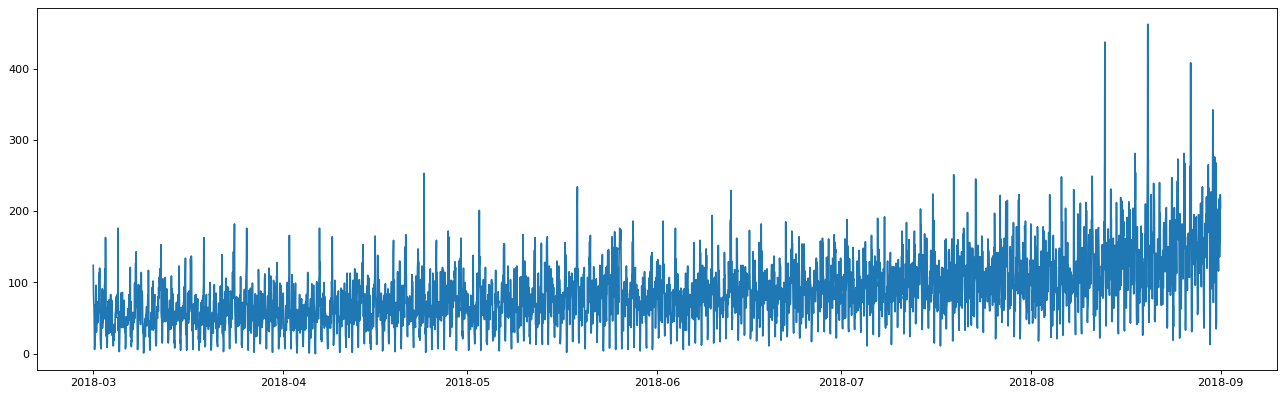

In [45]:
#построим график для наглядности представления информации

plt.figure(figsize=(20,6), dpi= 80)
plt.plot(df.index, df['num_orders'])

**Вывод**  
Как мы видим, столбецы имеют правильный тип данных, пропусков и дубликатов нет. Ресемплирование произведено. Промежуток времени для исследования определен. Данные чистые и готовы к дальнейшему анализу.

## Анализ

### Скользящее среднее

Опреелим скользяя среднее за день. Суть этой метрики заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

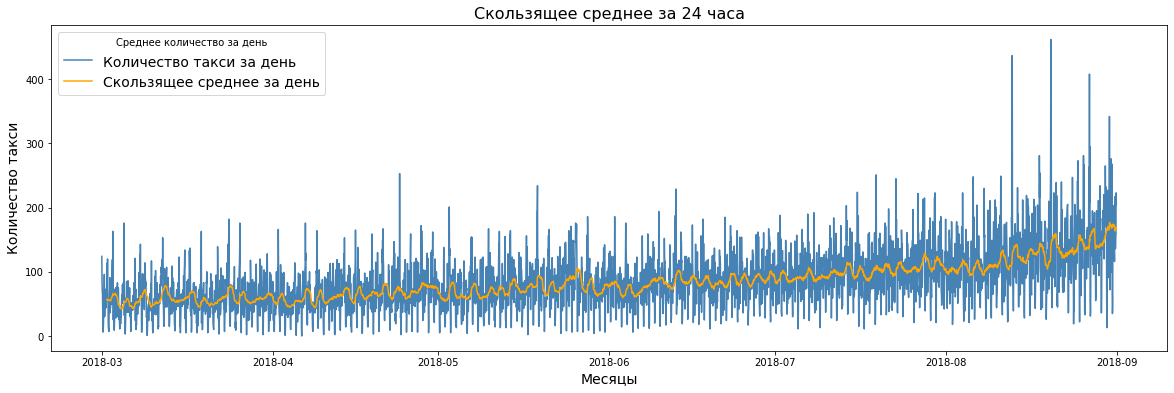

In [46]:
# зададим размер графика
plt.figure(figsize = (20,6))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(df, label = 'Количество такси за день', color = 'steelblue')
plt.plot(df.rolling(window = 24).mean(), label = 'Скользящее среднее за день', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = 'Среднее количество за день', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество такси', fontsize = 14)
plt.title('Скользящее среднее за 24 часа', fontsize = 16)
 
# выведем обе кривые на одном графике
plt.show()

Как мы видим, скользящее среднее сильно сглаживает показатели. 

###  Разложение временного ряда на компоненты

Выявление компонентов временного ряда (time series decomposition) предполагает его разложение на: 
 - Тренд — долгосрочное изменение уровня ряда
 - Сезонность - предполагает циклические изменения уровня ряда с постоянным периодом
 - Случайные колебания — непрогнозируемое случайное изменение ряда.    
 Воспользуемся функцией seasonal_decompose() для определения этих парметров.

Text(0.5, 1.0, 'Daily Seasonality')

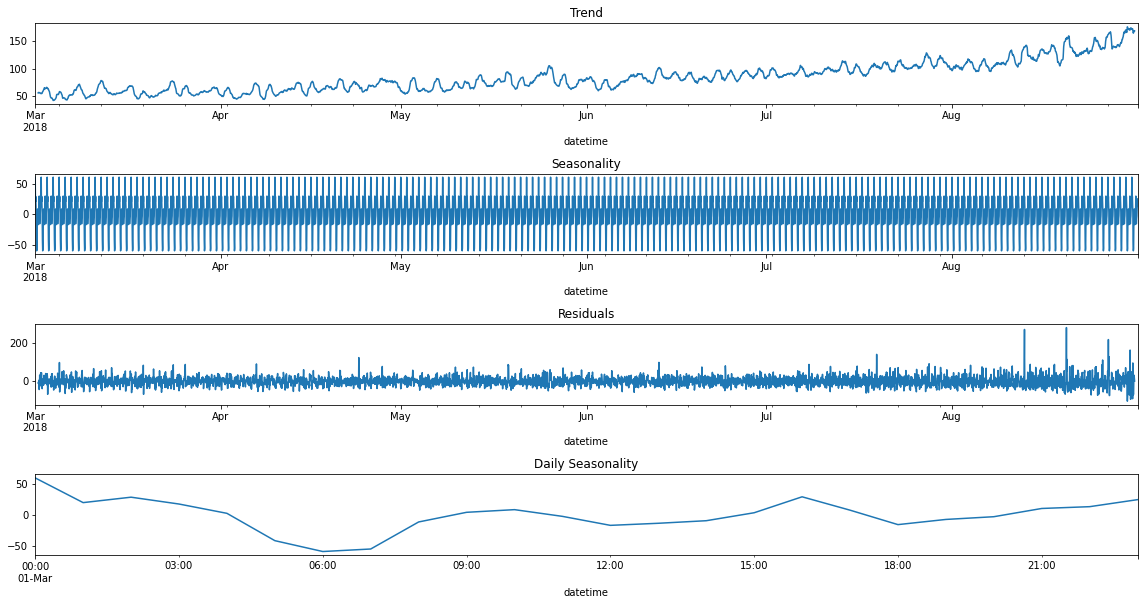

In [47]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 10))
plt.subplot(511)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(513)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()
#посмотрим ежедневную сезонность 
plt.subplot(514)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-01 23:00:00'].plot(ax=plt.gca())
plt.title('Daily Seasonality')

На графике видно возрастание тренда, начиная с мая, увеличение случайных колебаний к концу августа и также стоит отметить ежедневную сезонность(в полночь -пик, в 06:00 - минимум заказов такси).

### Стационарность временного ряда

О стационарности говорят отсутствие таких компонентов как тренд и сезонность. В условиях нашей задачи, мы увидели, что тренд возрастает. Значит временной ряд нестационарен. Для более точной оценки стационарности можно применить тест Дики-Фуллера.

В данном случае гипотезы звучат следующим образом:    
- Нулевая гипотеза предполагает, что процесс стационарный.    
- Альтернативная гипотеза соответственно говорит об обратном. 

Используем пороговое значение, равное 0,05 (5%).

In [48]:
# передадим ей столбец с данными 
adf_test = adfuller(df['num_orders'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402612906


Как мы видим, вероятность (p-value) для данных о количестве вызванных такси в день, ниже 0,05. Мы не можем отвергнуть нулевую гипотезу, предполагающую стационарность временного ряда.

## Обучение

### Создание признаков

In [49]:
def make_features(df, column, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5,6])*1
    df['hours'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[column].shift(lag)

    df['rolling_mean'] = df[column].shift().rolling( rolling_mean_size).mean()


In [50]:
make_features(df, 'num_orders', 24, 12)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   dayofweek     4392 non-null   int64  
 2   is_weekend    4392 non-null   int64  
 3   hours         4392 non-null   int64  
 4   lag_1         4392 non-null   float64
 5   lag_2         4392 non-null   float64
 6   lag_3         4392 non-null   float64
 7   lag_4         4392 non-null   float64
 8   lag_5         4392 non-null   float64
 9   lag_6         4392 non-null   float64
 10  lag_7         4392 non-null   float64
 11  lag_8         4392 non-null   float64
 12  lag_9         4392 non-null   float64
 13  lag_10        4392 non-null   float64
 14  lag_11        4392 non-null   float64
 15  lag_12        4392 non-null   float64
 16  lag_13        4392 non-null   float64
 17  lag_14        4392 non-null

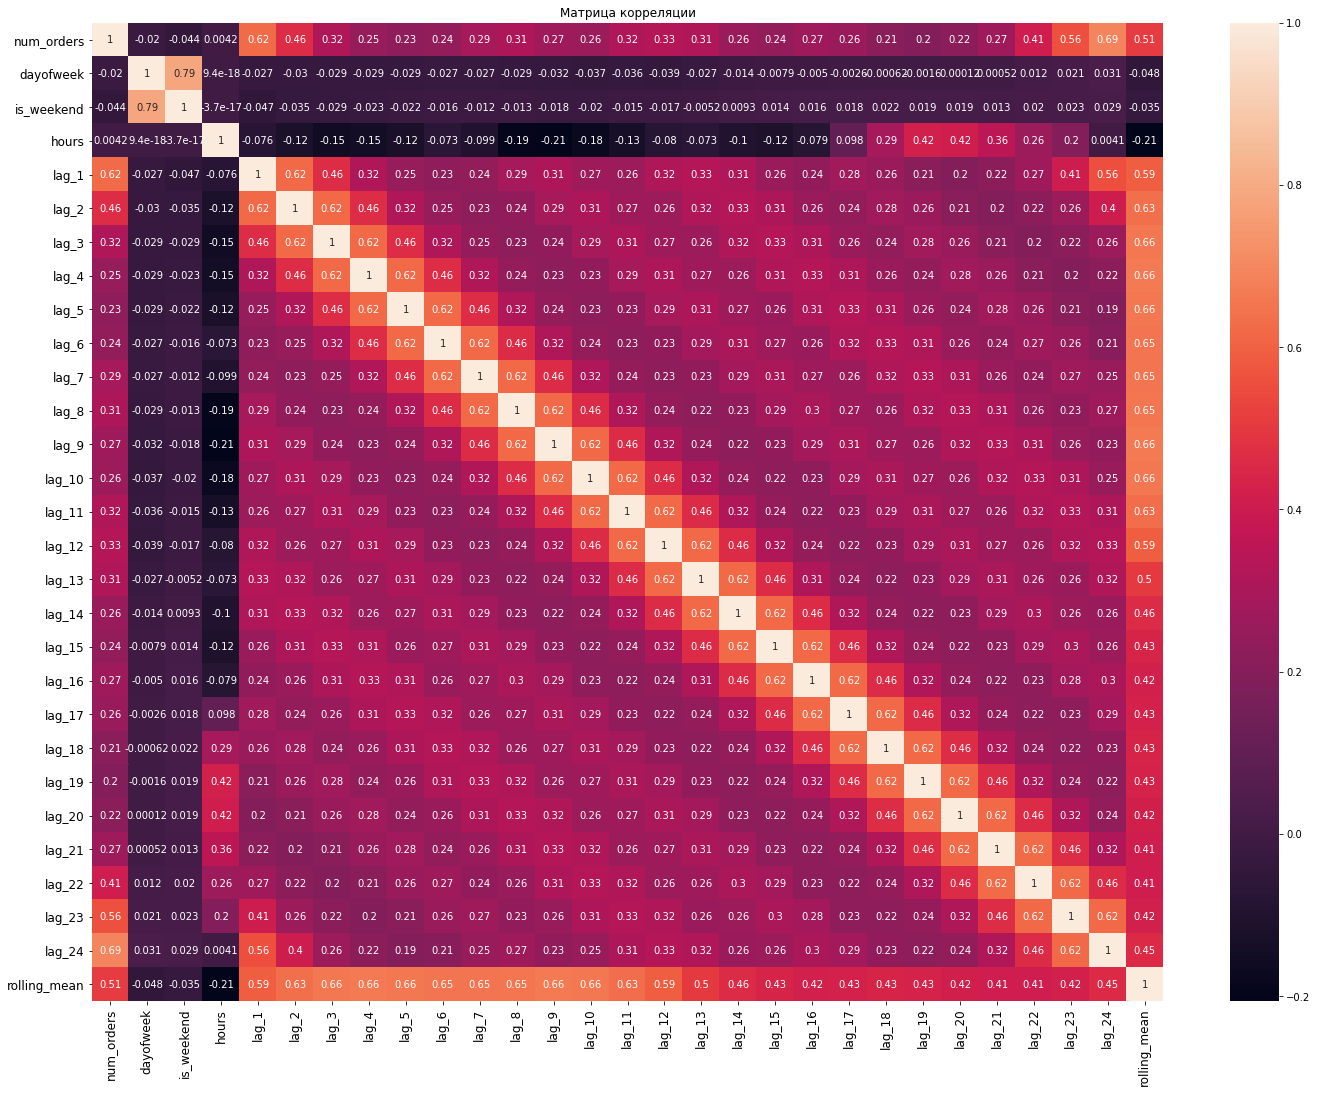

In [51]:
#изучим корреляцию
plt.figure(figsize=(24,18))
sns.heatmap(df.corr(), annot = True, fmt='.2g')
plt.title('Матрица корреляции')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Из таблицы с результатами корреляции мы видим сильную линейную зависимость с часами начиная с 11  вечера до 2 часов ночи следующего дня, что подтверждает наши данные полученные ранее.

In [52]:
#разделим данные на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print(train.shape)
print(test.shape)
#извлечем принзаки для обучающей выборки
features_train = train.drop(['num_orders'], axis=1) # извлекаем признаки
target_train = train['num_orders'] # извлекаем целевой признак
#извлечем принзаки для тестовой выборки
features_test = test.drop(['num_orders'], axis=1) # извлекаем признаки
target_test = test['num_orders'] # извлекаем целевой признак

(3952, 29)
(440, 29)


In [53]:
# создадим кросс-валидатор для последующего обучения моделей
cv = KFold(n_splits=3, shuffle=True, random_state=12345)
# словарь для результатов обучения
train_score = {}

### LinearRegression

In [54]:
# задаём число фолдов для кросс-валидации
tscv = TimeSeriesSplit(n_splits=3) 

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

predicted_train = lr_model.predict(features_train)
rmse_train = (mean_squared_error(target_train, predicted_train))**0.5 

best_score_lr = cross_val_score(lr_model, features_train, target_train, scoring='neg_mean_squared_error', cv=tscv)*(-1)
best_score_lr = best_score_lr.mean()

train_score['LinearRegression'] = [rmse_train, best_score_lr]
display(train_score['LinearRegression'])

[25.78838798652039, 776.839110963112]

### DecisionTreeRegressor

In [55]:
dtc = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range (1, 11, 1),
             'min_samples_split': range (2,10,2)}
grid = GridSearchCV(dtc, parameters, cv=cv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)

best_score_dtr = grid.best_score_ *(-1)
print("Best score: %0.3f" % best_score_dtr)

print("Best parameters set:")
best_parameters_dtr = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters_dtr[param_name]))

Best score: 757.577
Best parameters set:
	max_depth: 5
	min_samples_split: 2


In [56]:
dtc_model = DecisionTreeRegressor(random_state=12345, max_depth=5, min_samples_split=2) # обучим модель с заданной глубиной дерева
dtc_model.fit(features_train,target_train) # обучим модель вызовом метода fit()
    
predicted_train = dtc_model.predict(features_train) # получим предсказания модели
rmse_train = (mean_squared_error(target_train, predicted_train))**0.5 

train_score['DecisionTreeRegressor'] = [rmse_train, best_score_dtr]
display(train_score['DecisionTreeRegressor'])

[24.561576047444955, 757.5773649255339]

### LightGBM

In [57]:
lgbm = LGBMRegressor(random_state=12345)
parameters = {'n_estimators': range (10, 101, 10),
#             'max_depth':[5, 10, 15]}
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15]}
gsearch = GridSearchCV(lgbm, parameters, cv=cv,scoring='neg_mean_squared_error')
gsearch.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
                         'n_estimators': range(10, 101, 10)},
             scoring='neg_mean_squared_error')

In [58]:
best_score_lgbm = gsearch.best_score_ * (-1)
print("Best score: %0.3f" % best_score_lgbm)

print("Best parameters set:")
best_parameters_lgbm = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters_lgbm[param_name]))

Best score: 496.713
Best parameters set:
	learning_rate: 0.05
	n_estimators: 100


In [59]:

booster = lgb.LGBMModel(objective="regression", n_estimators=100, learning_rate=0.05)
booster.fit(features_train, target_train)

predicted_train = booster.predict(features_train)
rmse_train_lgbm = (mean_squared_error(target_train, predicted_train))**0.5  

In [60]:
train_score['LightGBM'] = [rmse_train_lgbm, best_score_lgbm]
display(train_score['LightGBM'])

[15.810315745882587, 496.71298563923193]

In [61]:
#создадим сводную таблицу
df_score = pd.DataFrame.from_dict(data = train_score, orient='index', columns=['RMSE_train', 'best_score'])
display(df_score)

,RMSE_train,best_score
LinearRegression,25.788388,776.839111
DecisionTreeRegressor,24.561576,757.577365
LightGBM,15.810316,496.712986


<AxesSubplot:>

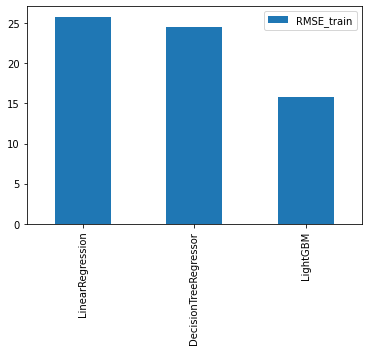

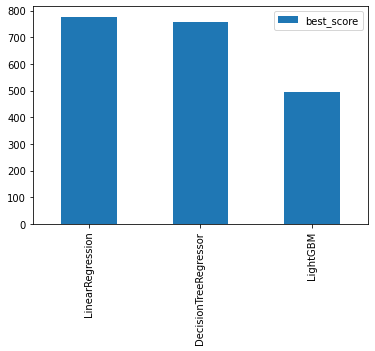

In [62]:
#для лучшей визуализации, построим графики
df_score.plot(kind="bar", y=['RMSE_train'])
df_score.plot(kind="bar", y=['best_score'])

Судя по полученным данным, наименьшее значение метрики RMSE у модели LightGBM. Выберем ее как лучшую модель и протестируем.

## Тестирование

### LinearRegression тестирование

In [63]:
lr_model.fit(features_train, target_train)
predicted_test_lr = lr_model.predict(features_test)
rmse_test_lr = (mean_squared_error(target_test, predicted_test_lr))**0.5  
print("RMSE модели на тестовой выборке:", rmse_test_lr)

best_score_lr_test = cross_val_score(lr_model, features_test, target_test, scoring='neg_mean_squared_error', cv=tscv)*(-1)
best_score_lr_test = best_score_lr.mean()
print("Best score_test: %0.3f" % best_score_lr_test)


RMSE модели на тестовой выборке: 45.167355691317645
Best score_test: 776.839


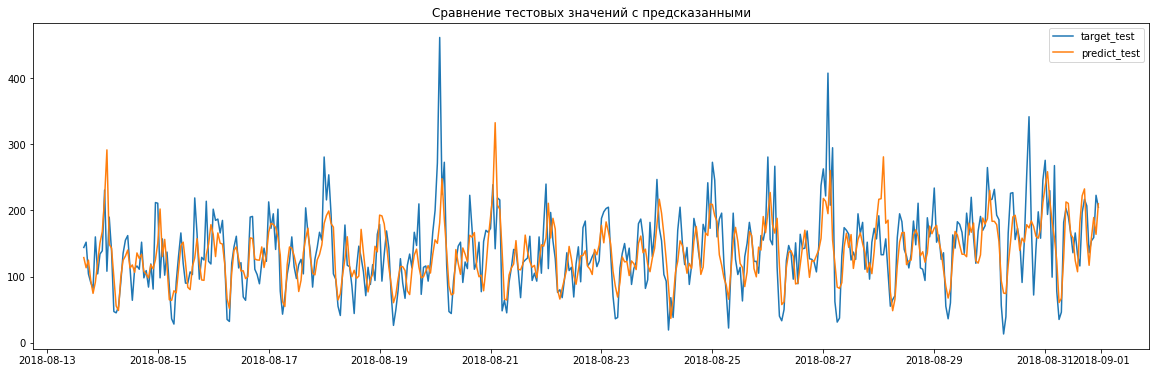

In [64]:
#построим график для наглядности представления информации
plt.figure(figsize = (20,6))
plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predicted_test_lr, label='predict_test')

plt.title('Сравнение тестовых значений с предсказанными')
plt.legend()
plt.show()

### DecisionTreeRegressor тестирование

In [65]:
grid.fit(features_test, target_test)

best_score_dtr_test = grid.best_score_ *(-1)
print("Best score: %0.3f" % best_score_dtr_test)

dtc_model_test = DecisionTreeRegressor(random_state=12345, max_depth=5, min_samples_split=2) # обучим модель с заданной глубиной дерева
dtc_model_test.fit(features_train,target_train) # обучим модель вызовом метода fit()
    
predicted_test_dts = dtc_model.predict(features_test) # получим предсказания модели
rmse_test_dtc = (mean_squared_error(target_test, predicted_test_dts))**0.5 
print("RMSE модели на тестовой выборке:", rmse_test_dtc)

Best score: 2031.064
RMSE модели на тестовой выборке: 52.435669468451735


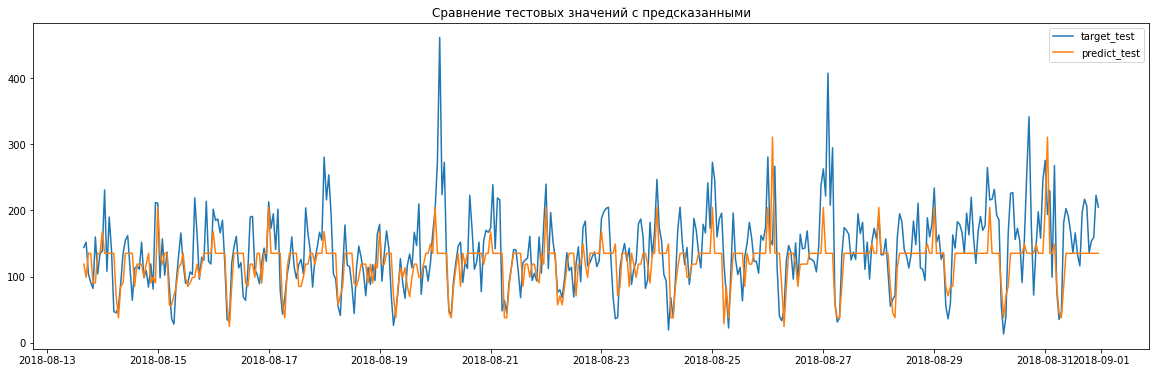

In [66]:
#построим график для наглядности представления информации
plt.figure(figsize = (20,6))
plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predicted_test_dts, label='predict_test')

plt.title('Сравнение тестовых значений с предсказанными')
plt.legend()
plt.show()

### LightGBM тестирование

In [67]:
gsearch.fit(features_test, target_test)

best_score_test = gsearch.best_score_ * (-1)
print("Best score_test: %0.3f" % best_score_test)

booster_test = lgb.LGBMModel(objective="regression", n_estimators=100, learning_rate=0.05)
booster_test.fit(features_train, target_train)

predicted_test_lgbm = booster_test.predict(features_test)
rmse_test_lgbm = (mean_squared_error(target_test, predicted_test_lgbm))**0.5  

print("RMSE модели на тестовой выборке:", rmse_test_lgbm)


Best score_test: 1691.467
RMSE модели на тестовой выборке: 42.55826915598718


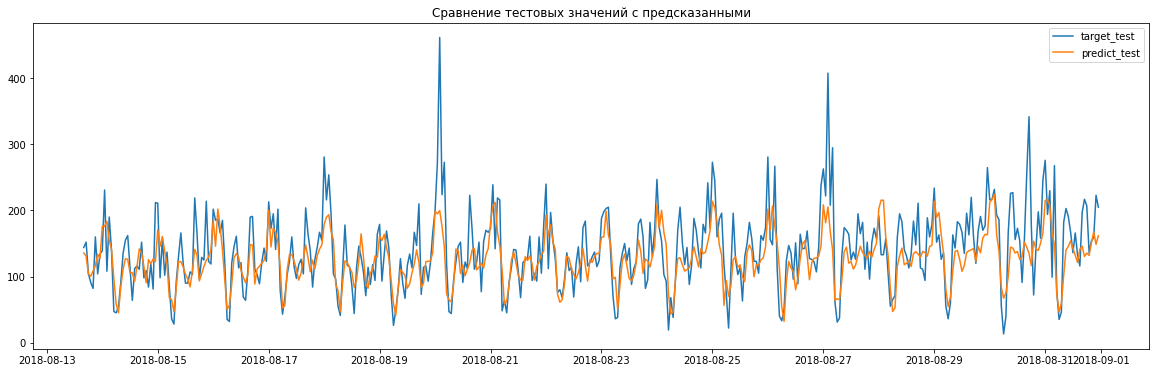

In [68]:
#построим график для наглядности представления информации
plt.figure(figsize = (20,6))
plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predicted_test_lgbm, label='predict_test')

plt.title('Сравнение тестовых значений с предсказанными')
plt.legend()
plt.show()

In [69]:
#создадим сводную таблицу
test_results = pd.DataFrame([['LinearRegression', rmse_test_lr, best_score_lr_test],
                           ['DecisionTreeRegressor', rmse_test_dtc, best_score_dtr_test],
                           ['LightGBM', rmse_test_lgbm, best_score_test]],
                           columns = ['model', 'RMSE_test', 'best_score_test'])
display(test_results)

,model,RMSE_test,best_score_test
0,LinearRegression,45.167356,776.839111
1,DecisionTreeRegressor,52.435669,2031.063998
2,LightGBM,42.558269,1691.466589


Лучшей моделью в нашем случае является LightGBM. У нее лучшие результаты как на тренировочной, так и на тестовой выборке. 